In [130]:
import numpy as np
import pandas as pd
from torch import nn
from phmd import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from scipy.stats import kurtosis
from scipy.fft import fft
from scipy.fft import fft, fftfreq
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from tqdm import tqdm
from scipy.signal import stft
from scipy.stats import kurtosis
from torchsummary import summary
from tabulate import tabulate

In [6]:
TRAIN_BEARINGS = {
    1: [
        '1_1',
        # '1_2',
    ],
    2: [
        '2_1',
        '2_2',
    ],
    3: [
        '3_1',
        '3_2',
    ]
}

TEST_BEARINGS = {
    1: [
        '1_3',
        '1_4',
        '1_5',
        '1_6',
        '1_7',
    ],
    2: [
        '2_3',
        '2_4',
        '2_5',
        '2_6',
        '2_7',
    ],
    3: [
        '3_3',
    ]
}

In [7]:
datasets.Dataset('PRONOSTIA').describe()

PRONOSTIA

Description
The IEEE PHM data challenge in 2012 utilized a renowned dataset provided by the FEMTO-ST Institute. The dataset originated from experiments conducted on a laboratory experimental platform known as PRONOSTIA, designed for accelerated degradation testing of bearings under various operating conditions. During these experiments, online health monitoring data including rotating speed, load force, temperature, and vibration were collected.

The dataset considered data from three different loads, encompassing rotating speed and load force variations. A total of 6 run-to-failure bearings were designated for building prognostic models, while an additional 11 bearings were allocated for testing purposes.

One notable characteristic of the challenge datasets was the relatively small amount of training data available, coupled with a high variability in experiment durations ranging from 1 to 7 hours. This variability posed a significant challenge in accurately estimating prog

In [8]:
dataset = datasets.Dataset('PRONOSTIA')
tasks = dataset['rul']
df = tasks.load()

Remember to cite the original publisher dataset:
	@inproceedings{nectoux2012pronostia,    
	    title={PRONOSTIA: An experimental platform for bearings accelerated degradation tests.},    
	    author={Nectoux, Patrick and Gouriveau, Rafael and Medjaher, Kamal and Ramasso, Emmanuel and Chebel-Morello, Brigitte and Zerhouni, Noureddine and Varnier, Christophe},    
	    booktitle={IEEE International Conference on Prognostics and Health Management, PHM'12.},    
	    pages={1--8},    
	    year={2012},    
	    organization={IEEE Catalog Number: CPF12PHM-CDR}    
	}
You can download the dataset manually from:  https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/

** If you find this tool useful, please cite our SoftwareX paper: 
	Solís-Martín, David, Juan Galán-Páez, and Joaquín Borrego-Díaz. "PHMD: An easy data access tool for prognosis and health management datasets." SoftwareX 29 (2025): 102039.



Reading Bearing3_3: 100%|██████████| 13959/13959 [00:39<00:00, 355.84it/s]
INFO:root:Read in 64.48553395271301 seconds


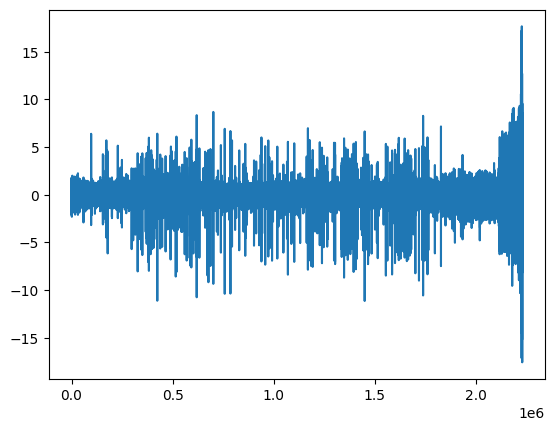

In [29]:
d_1_1 = df[0][df[0]['unit'] == '1_1']
d_1_2 = df[0][df[0]['unit'] == '1_2']
d_2_1 = df[0][df[0]['unit'] == '2_1']
d_2_2 = df[0][df[0]['unit'] == '2_2']
d_3_1 = df[0][df[0]['unit'] == '3_1']
d_3_2 = df[0][df[0]['unit'] == '3_2']

plt.plot(d_1_2['H_acc'])

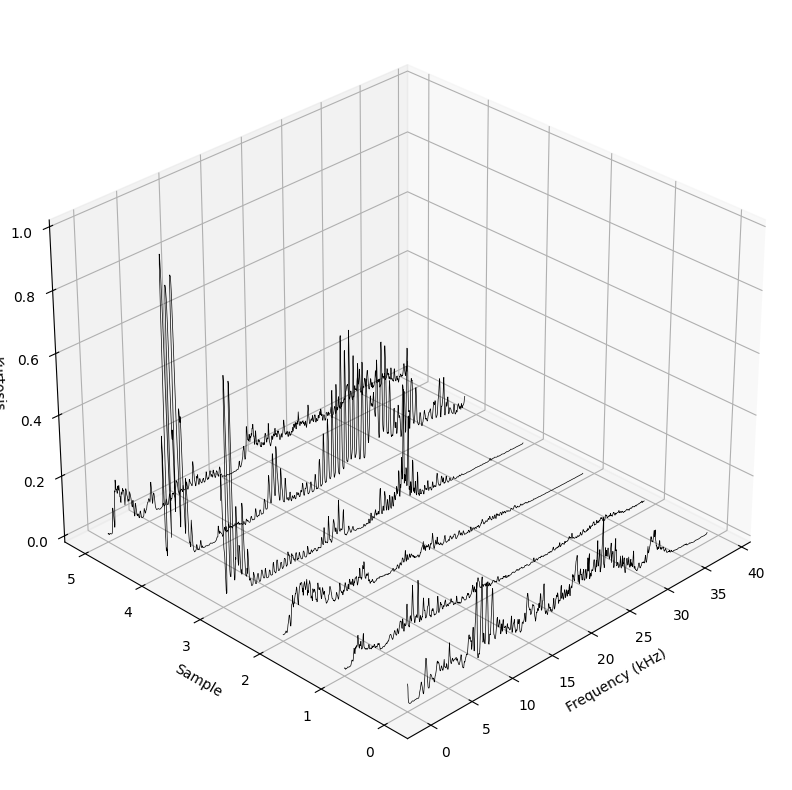

In [58]:
f = []
ffts = []

nperseg = 1024

for d in [
    d_1_1,
    d_1_2,
    d_2_1,
    d_2_2,
    d_3_1,
    d_3_2
]:
    vibration_signal = (d['H_acc'] - np.mean(d['H_acc'])) / np.std(d['H_acc'])
    u,v,w = stft(vibration_signal, 25.6 * 1000, nperseg=nperseg,noverlap = 512, window='hann', nfft=2048)
    f.append(u)
    ffts.append(kurtosis(np.abs(w),fisher = False,axis = 1))

f = np.asarray(f)
ffts = np.asarray(ffts)

fftn = (ffts - ffts.min()) / (ffts.max() - ffts.min())

fftn = np.asarray(fftn)
n = np.ones_like(f[0])

fig = plt.figure(figsize = (10.0,10.0))
ax = plt.axes(projection = '3d')
ax.view_init(30,225)
for i in range(f.shape[0]):
    ax.plot((f[i] * 3) / 1.0e3,i * n,fftn[i],color = 'black',linewidth = 0.50)

ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Sample')
ax.set_zlabel('Kurtosis')
plt.show()

In [5]:
# train
df[0]['unit'].unique()

array(['1_1', '1_2', '2_1', '2_2', '3_1', '3_2'], dtype=object)

In [6]:
df[0].head(5)

,rul,V_acc,H_acc,unit
0,28029,-0.146,0.552,1_1
1,28029,-0.480,0.501,1_1
2,28029,0.435,0.138,1_1
3,28029,0.240,-0.423,1_1
4,28029,0.020,-0.802,1_1


In [7]:
# test
df[1]['unit'].unique()

array(['1_3', '1_4', '1_5', '1_6', '1_7', '2_3', '2_4', '2_5', '2_6',
       '2_7', '3_3'], dtype=object)

In [8]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]['unit']

0          1_1
1          1_1
2          1_1
3          1_1
4          1_1
          ... 
7175675    1_1
7175676    1_1
7175677    1_1
7175678    1_1
7175679    1_1
Name: unit, Length: 7175680, dtype: object

In [9]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]

,rul,V_acc,H_acc,unit
0,28029,-0.146,0.552,1_1
1,28029,-0.480,0.501,1_1
2,28029,0.435,0.138,1_1
3,28029,0.240,-0.423,1_1
4,28029,0.020,-0.802,1_1
...,...,...,...,...
7175675,0,2.129,-3.353,1_1
7175676,0,-2.299,-2.868,1_1
7175677,0,-1.844,-5.507,1_1
7175678,0,2.146,-3.578,1_1


In [10]:
df[1][df[1]['unit'].isin(TEST_BEARINGS[1])]

,rul,V_acc,H_acc,unit
0,23749,0.044,0.092,1_3
1,23749,0.432,-0.025,1_3
2,23749,0.008,-0.104,1_3
3,23749,-0.264,0.056,1_3
4,23749,-0.195,0.074,1_3
...,...,...,...,...
3845115,7570,-0.013,0.481,1_7
3845116,7570,-0.272,0.191,1_7
3845117,7570,0.466,0.250,1_7
3845118,7570,-0.582,0.001,1_7


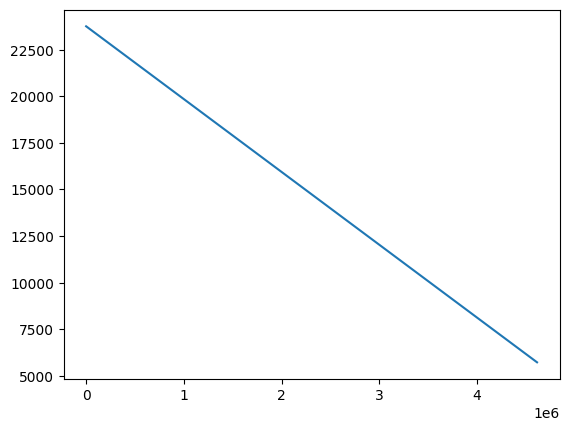

In [11]:
plt.plot(df[1][df[1]['unit'] == '1_3']['rul'])

In [12]:
# sns.kdeplot(df[0][df[0]['unit'] == '1_1']['H_acc'], label='Train')
# sns.kdeplot(test_features['h_RMS'], label='Test')
# plt.legend(); plt.show()

In [126]:
class BearingDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=2560, step=2560 // 2):
        self.windows = []
        self.ruls = []
        
        # Create sequences
        for _, group in df.groupby('unit'):
            h_acc =  group['H_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
            v_acc =  group['V_acc'].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )

            rul = group['rul'].transform(lambda x: x / x.max())

            for i in range(0, len(group) - window_size, step):

                self.windows.append(np.stack([
                    h_acc[i:i+window_size], 
                    v_acc[i:i+window_size]
                ], axis=1))
                self.ruls.append(rul.values[i+window_size-1])

    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.windows[idx]), torch.FloatTensor([self.ruls[idx]])
    
train_dataset = BearingDataset(
    # [b for state in TRAIN_BEARINGS for b in TRAIN_BEARINGS[state]]
    df=df[0][df[0]['unit'].isin(['3_2'])],
)

test_dataset = BearingDataset(
    df=df[1][df[1]['unit'] == '3_3'],
)

val_dataset = BearingDataset(
    df=df[0][df[0]['unit'] == '3_1'],
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [114]:
len(train_dataset)

1820

In [207]:
class BearingCNN(torch.nn.Module):
    def __init__(self):
        super(BearingCNN, self).__init__()
        
        # Feature extractor
        self.features = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=5, stride=1, padding=2),  # [32, 16, 2560]
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),                  # [32, 16, 1280]
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),  # [32, 32, 1280]
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),                  # [32, 32, 640]
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),  # [32, 64, 640]
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)                                 # [32, 64, 1]
        )
        
        # Regressor
        self.regressor = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.features(x)       # [32, 64, 1]
        x = x.squeeze(-1)          # [32, 64]
        x = self.regressor(x)      # [32, 1]
        return x

model = BearingCNN()
# model.load_state_dict(torch.load('last_r2_model.pth', weights_only=True))

In [208]:
# def model_summary_table(model, input_shape):
#     # Get summary as a string
#     summary_str = []
#     def hook(module, input, output):
#         summary_str.append([
#             module.__class__.__name__,
#             list(input[0].shape) if isinstance(input, tuple) else input.shape,
#             list(output.shape),
#             sum(p.numel() for p in module.parameters())
#         ])
    
#     # Register hooks
#     hooks = []
#     for layer in model.children():
#         hooks.append(layer.register_forward_hook(hook))
    
#     # Dummy forward pass
#     dummy_input = torch.randn(input_shape)
#     model(dummy_input)
    
#     # Remove hooks
#     for hook in hooks:
#         hook.remove()
    
#     # Print table
#     headers = ["Layer (type)", "Input Shape", "Output Shape", "Param #"]
#     print(tabulate(summary_str, headers=headers, tablefmt="grid"))

# summary(model, input_size=(2560, 2))

In [209]:
class LogCoshLoss(nn.Module):
    def forward(self, y_pred, y_true):
        return torch.mean(torch.log(torch.cosh(y_pred - y_true)))

def weighted_mse_loss(y_pred, y_true):
    alpha=2.0
    error = y_pred - y_true
    weights = torch.where(error < 0, alpha, 1.0)  # Heavier penalty for underestimating RUL
    return torch.mean(weights * (error ** 2))

def r2_score_loss(y_pred, y_true):
    # Calculate R² (Coefficient of Determination)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / (ss_tot + 1e-8))  # Avoid division by zero
    return -r2  # Minimize this (equivalent to maximizing R²)

def hybrid_r2_mse_loss(y_pred, y_true,):
    # alpha=0.5
    alpha = 0.7
    mse = torch.mean((y_pred - y_true) ** 2)
    r2 = r2_score_loss(y_pred, y_true)  # Returns -R²
    return alpha * mse + (1 - alpha) * r2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = hybrid_r2_mse_loss
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs,
):
    train_r2 = []
    train_mae = []
    train_mse = []
    train_rmse = []
    train_loss = []

    val_r2 = []
    val_mae = []
    val_mse = []
    val_rmse = []
    val_loss = []

    best_r2 = -float('inf')

    for epoch in range(epochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_preds = []
        epoch_train_targets = []

        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch).flatten()

            epoch_train_preds.append(y_pred)
            epoch_train_targets.append(y_batch)

            loss = criterion(y_pred, y_batch)
            
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        train_preds = torch.cat(epoch_train_preds).cpu().detach().numpy()
        train_targets = torch.cat(epoch_train_targets).cpu().detach().numpy()
        
        epoch_train_r2 = r2_score(train_targets, train_preds)
        epoch_train_mae = mean_absolute_error(train_targets, train_preds)
        epoch_train_mse = mean_squared_error(train_targets, train_preds)
        epoch_train_rmse = np.sqrt(epoch_train_mse)
        epoch_train_loss = epoch_train_loss/len(train_loader)
        
        train_r2.append(epoch_train_r2)
        train_mae.append(epoch_train_mae)
        train_mse.append(epoch_train_mse)
        train_rmse.append(epoch_train_rmse)
        train_loss.append(epoch_train_loss)
    
        print(
            f'Epoch {epoch + 1}: Train Loss {epoch_train_loss:.4f}, '
                + f'Train R2 = {epoch_train_r2:.3f}, '
                + f'Train RMSE = {epoch_train_rmse:.3f}, '
                + f'Train MSE = {epoch_train_mse:.3f}, '
                + f'Train MAE = {epoch_train_mae:.3f}'
        )


        model.eval()

        epoch_val_loss = 0
        epoch_val_preds = []
        epoch_val_targets = []

        with torch.no_grad():
            for X_val, y_val in tqdm(val_loader, desc=f'Epoch {epoch + 1} Val'):
                X_val, y_val = X_val.to(device), y_val.to(device)

                y_pred = model(X_val).flatten()

                epoch_val_preds.append(y_pred)
                epoch_val_targets.append(y_val)
                
                epoch_val_loss += criterion(y_pred, y_val).item()

        val_preds = torch.cat(epoch_val_preds).cpu().detach().numpy()
        val_targets = torch.cat(epoch_val_targets).cpu().detach().numpy()
        
        epoch_val_r2 = r2_score(val_targets, val_preds)
        epoch_val_mae = mean_absolute_error(val_targets, val_preds)
        epoch_val_mse = mean_squared_error(val_targets, val_preds)
        epoch_val_rmse = np.sqrt(epoch_val_mse)
        epoch_val_loss = epoch_val_loss/len(val_loader)
        # scheduler.step(epoch_val_loss)
        
        val_r2.append(epoch_val_r2)
        val_mae.append(epoch_val_mae)
        val_mse.append(epoch_val_mse)
        val_rmse.append(epoch_val_rmse)
        val_loss.append(epoch_val_loss)

        if val_r2[-1] > best_r2:
            best_r2 = val_r2[-1]
            torch.save(model.state_dict(), 'best_r2_model.pth')

        print(
            f'Epoch {epoch + 1}: Val Loss {epoch_val_loss:.4f}, '
                + f'Val R2 = {epoch_val_r2:.3f}, '
                + f'Val RMSE = {epoch_val_rmse:.3f}, '
                + f'Val MSE = {epoch_val_mse:.3f}, '
                + f'Val MAE = {epoch_val_mae:.3f}'
        ) 

    torch.save(model.state_dict(), 'last_r2_model.pth')

    return {
        'train_loss': train_loss,
        'train_r2': train_r2,
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'val_loss': val_loss,
        'val_r2': val_r2,
        'val_mae': val_mae,
        'val_mse': val_mse,
        'val_rmse': val_rmse,
    }

In [210]:
train_results = train(model, train_loader, val_loader, optimizer, criterion, device, 100)

train_results

100%|██████████| 103/103 [00:00<00:00, 189.91it/s]


Epoch 1: Train Loss 200552.1085, Train R2 = -0.823, Train RMSE = 0.390, Train MSE = 0.152, Train MAE = 0.281


Epoch 1 Val: 100%|██████████| 33/33 [00:00<00:00, 394.88it/s]


Epoch 1: Val Loss 26745.2435, Val R2 = -1.386, Val RMSE = 0.445, Val MSE = 0.198, Val MAE = 0.369


100%|██████████| 103/103 [00:00<00:00, 215.68it/s]


Epoch 2: Train Loss 218434.3607, Train R2 = -1.057, Train RMSE = 0.414, Train MSE = 0.171, Train MAE = 0.335


Epoch 2 Val: 100%|██████████| 33/33 [00:00<00:00, 452.21it/s]


Epoch 2: Val Loss 22174.5903, Val R2 = -0.895, Val RMSE = 0.397, Val MSE = 0.157, Val MAE = 0.326


100%|██████████| 103/103 [00:00<00:00, 213.07it/s]


Epoch 3: Train Loss 187601.1264, Train R2 = -0.774, Train RMSE = 0.384, Train MSE = 0.148, Train MAE = 0.317


Epoch 3 Val: 100%|██████████| 33/33 [00:00<00:00, 435.18it/s]


Epoch 3: Val Loss 20174.8339, Val R2 = -0.695, Val RMSE = 0.375, Val MSE = 0.141, Val MAE = 0.309


100%|██████████| 103/103 [00:00<00:00, 222.11it/s]


Epoch 4: Train Loss 167526.7113, Train R2 = -0.603, Train RMSE = 0.365, Train MSE = 0.133, Train MAE = 0.305


Epoch 4 Val: 100%|██████████| 33/33 [00:00<00:00, 424.02it/s]


Epoch 4: Val Loss 17801.8988, Val R2 = -0.479, Val RMSE = 0.351, Val MSE = 0.123, Val MAE = 0.290


100%|██████████| 103/103 [00:00<00:00, 221.50it/s]


Epoch 5: Train Loss 148044.6569, Train R2 = -0.441, Train RMSE = 0.346, Train MSE = 0.120, Train MAE = 0.292


Epoch 5 Val: 100%|██████████| 33/33 [00:00<00:00, 412.27it/s]


Epoch 5: Val Loss 16104.3217, Val R2 = -0.384, Val RMSE = 0.339, Val MSE = 0.115, Val MAE = 0.281


100%|██████████| 103/103 [00:00<00:00, 218.23it/s]


Epoch 6: Train Loss 134340.0108, Train R2 = -0.326, Train RMSE = 0.332, Train MSE = 0.110, Train MAE = 0.282


Epoch 6 Val: 100%|██████████| 33/33 [00:00<00:00, 440.89it/s]


Epoch 6: Val Loss 14781.8282, Val R2 = -0.328, Val RMSE = 0.332, Val MSE = 0.110, Val MAE = 0.276


100%|██████████| 103/103 [00:00<00:00, 220.91it/s]


Epoch 7: Train Loss 126118.7264, Train R2 = -0.259, Train RMSE = 0.324, Train MSE = 0.105, Train MAE = 0.276


Epoch 7 Val: 100%|██████████| 33/33 [00:00<00:00, 471.34it/s]


Epoch 7: Val Loss 13739.4038, Val R2 = -0.288, Val RMSE = 0.327, Val MSE = 0.107, Val MAE = 0.271


100%|██████████| 103/103 [00:00<00:00, 212.06it/s]


Epoch 8: Train Loss 121271.4966, Train R2 = -0.213, Train RMSE = 0.318, Train MSE = 0.101, Train MAE = 0.271


Epoch 8 Val: 100%|██████████| 33/33 [00:00<00:00, 447.38it/s]


Epoch 8: Val Loss 13788.0774, Val R2 = -0.297, Val RMSE = 0.328, Val MSE = 0.108, Val MAE = 0.272


100%|██████████| 103/103 [00:00<00:00, 219.54it/s]


Epoch 9: Train Loss 119410.8275, Train R2 = -0.194, Train RMSE = 0.315, Train MSE = 0.099, Train MAE = 0.269


Epoch 9 Val: 100%|██████████| 33/33 [00:00<00:00, 462.47it/s]


Epoch 9: Val Loss 12703.5359, Val R2 = -0.265, Val RMSE = 0.324, Val MSE = 0.105, Val MAE = 0.267


100%|██████████| 103/103 [00:00<00:00, 215.52it/s]


Epoch 10: Train Loss 118485.5123, Train R2 = -0.182, Train RMSE = 0.314, Train MSE = 0.098, Train MAE = 0.269


Epoch 10 Val: 100%|██████████| 33/33 [00:00<00:00, 437.58it/s]


Epoch 10: Val Loss 13350.7610, Val R2 = -0.217, Val RMSE = 0.318, Val MSE = 0.101, Val MAE = 0.265


100%|██████████| 103/103 [00:00<00:00, 217.45it/s]


Epoch 11: Train Loss 118328.5289, Train R2 = -0.184, Train RMSE = 0.314, Train MSE = 0.099, Train MAE = 0.269


Epoch 11 Val: 100%|██████████| 33/33 [00:00<00:00, 444.16it/s]


Epoch 11: Val Loss 11684.7775, Val R2 = -0.163, Val RMSE = 0.311, Val MSE = 0.097, Val MAE = 0.258


100%|██████████| 103/103 [00:00<00:00, 217.92it/s]


Epoch 12: Train Loss 111343.1006, Train R2 = -0.114, Train RMSE = 0.304, Train MSE = 0.093, Train MAE = 0.263


Epoch 12 Val: 100%|██████████| 33/33 [00:00<00:00, 426.46it/s]


Epoch 12: Val Loss 12441.7214, Val R2 = -0.170, Val RMSE = 0.312, Val MSE = 0.097, Val MAE = 0.261


100%|██████████| 103/103 [00:00<00:00, 224.94it/s]


Epoch 13: Train Loss 114940.2843, Train R2 = -0.149, Train RMSE = 0.309, Train MSE = 0.096, Train MAE = 0.266


Epoch 13 Val: 100%|██████████| 33/33 [00:00<00:00, 444.88it/s]


Epoch 13: Val Loss 11185.1950, Val R2 = -0.121, Val RMSE = 0.305, Val MSE = 0.093, Val MAE = 0.254


100%|██████████| 103/103 [00:00<00:00, 217.14it/s]


Epoch 14: Train Loss 110325.0519, Train R2 = -0.103, Train RMSE = 0.303, Train MSE = 0.092, Train MAE = 0.262


Epoch 14 Val: 100%|██████████| 33/33 [00:00<00:00, 378.71it/s]


Epoch 14: Val Loss 12277.7893, Val R2 = -0.158, Val RMSE = 0.310, Val MSE = 0.096, Val MAE = 0.260


100%|██████████| 103/103 [00:00<00:00, 216.82it/s]


Epoch 15: Train Loss 112134.3886, Train R2 = -0.114, Train RMSE = 0.305, Train MSE = 0.093, Train MAE = 0.263


Epoch 15 Val: 100%|██████████| 33/33 [00:00<00:00, 443.01it/s]


Epoch 15: Val Loss 10822.0978, Val R2 = -0.106, Val RMSE = 0.303, Val MSE = 0.092, Val MAE = 0.252


100%|██████████| 103/103 [00:00<00:00, 219.75it/s]


Epoch 16: Train Loss 108280.7360, Train R2 = -0.077, Train RMSE = 0.299, Train MSE = 0.090, Train MAE = 0.260


Epoch 16 Val: 100%|██████████| 33/33 [00:00<00:00, 395.31it/s]


Epoch 16: Val Loss 11663.2458, Val R2 = -0.093, Val RMSE = 0.301, Val MSE = 0.091, Val MAE = 0.254


100%|██████████| 103/103 [00:00<00:00, 218.57it/s]


Epoch 17: Train Loss 109124.4847, Train R2 = -0.093, Train RMSE = 0.302, Train MSE = 0.091, Train MAE = 0.261


Epoch 17 Val: 100%|██████████| 33/33 [00:00<00:00, 484.72it/s]


Epoch 17: Val Loss 10444.7413, Val R2 = -0.057, Val RMSE = 0.296, Val MSE = 0.088, Val MAE = 0.248


100%|██████████| 103/103 [00:00<00:00, 220.87it/s]


Epoch 18: Train Loss 104183.5633, Train R2 = -0.045, Train RMSE = 0.295, Train MSE = 0.087, Train MAE = 0.256


Epoch 18 Val: 100%|██████████| 33/33 [00:00<00:00, 439.07it/s]


Epoch 18: Val Loss 10449.8291, Val R2 = -0.051, Val RMSE = 0.295, Val MSE = 0.087, Val MAE = 0.248


100%|██████████| 103/103 [00:00<00:00, 214.53it/s]


Epoch 19: Train Loss 102803.4001, Train R2 = -0.027, Train RMSE = 0.292, Train MSE = 0.085, Train MAE = 0.253


Epoch 19 Val: 100%|██████████| 33/33 [00:00<00:00, 456.99it/s]


Epoch 19: Val Loss 10388.1634, Val R2 = -0.067, Val RMSE = 0.298, Val MSE = 0.089, Val MAE = 0.247


100%|██████████| 103/103 [00:00<00:00, 224.45it/s]


Epoch 20: Train Loss 100791.4210, Train R2 = -0.009, Train RMSE = 0.290, Train MSE = 0.084, Train MAE = 0.251


Epoch 20 Val: 100%|██████████| 33/33 [00:00<00:00, 437.89it/s]


Epoch 20: Val Loss 10430.1276, Val R2 = -0.051, Val RMSE = 0.295, Val MSE = 0.087, Val MAE = 0.247


100%|██████████| 103/103 [00:00<00:00, 208.13it/s]


Epoch 21: Train Loss 99842.7971, Train R2 = 0.006, Train RMSE = 0.288, Train MSE = 0.083, Train MAE = 0.249


Epoch 21 Val: 100%|██████████| 33/33 [00:00<00:00, 434.06it/s]


Epoch 21: Val Loss 9929.4254, Val R2 = -0.027, Val RMSE = 0.292, Val MSE = 0.085, Val MAE = 0.243


100%|██████████| 103/103 [00:00<00:00, 215.18it/s]


Epoch 22: Train Loss 94766.8154, Train R2 = 0.050, Train RMSE = 0.281, Train MSE = 0.079, Train MAE = 0.244


Epoch 22 Val: 100%|██████████| 33/33 [00:00<00:00, 438.90it/s]


Epoch 22: Val Loss 9921.3394, Val R2 = -0.014, Val RMSE = 0.290, Val MSE = 0.084, Val MAE = 0.243


100%|██████████| 103/103 [00:00<00:00, 222.80it/s]


Epoch 23: Train Loss 94500.7783, Train R2 = 0.060, Train RMSE = 0.280, Train MSE = 0.078, Train MAE = 0.242


Epoch 23 Val: 100%|██████████| 33/33 [00:00<00:00, 444.22it/s]


Epoch 23: Val Loss 9445.4055, Val R2 = 0.023, Val RMSE = 0.285, Val MSE = 0.081, Val MAE = 0.238


100%|██████████| 103/103 [00:00<00:00, 216.91it/s]


Epoch 24: Train Loss 87112.0999, Train R2 = 0.130, Train RMSE = 0.269, Train MSE = 0.072, Train MAE = 0.233


Epoch 24 Val: 100%|██████████| 33/33 [00:00<00:00, 471.27it/s]


Epoch 24: Val Loss 9531.6475, Val R2 = 0.028, Val RMSE = 0.284, Val MSE = 0.081, Val MAE = 0.239


100%|██████████| 103/103 [00:00<00:00, 214.10it/s]


Epoch 25: Train Loss 86829.1312, Train R2 = 0.142, Train RMSE = 0.267, Train MSE = 0.071, Train MAE = 0.229


Epoch 25 Val: 100%|██████████| 33/33 [00:00<00:00, 450.28it/s]


Epoch 25: Val Loss 8955.5784, Val R2 = 0.080, Val RMSE = 0.276, Val MSE = 0.076, Val MAE = 0.233


100%|██████████| 103/103 [00:00<00:00, 214.64it/s]


Epoch 26: Train Loss 76686.7657, Train R2 = 0.236, Train RMSE = 0.252, Train MSE = 0.064, Train MAE = 0.217


Epoch 26 Val: 100%|██████████| 33/33 [00:00<00:00, 452.77it/s]


Epoch 26: Val Loss 8884.5290, Val R2 = 0.095, Val RMSE = 0.274, Val MSE = 0.075, Val MAE = 0.232


100%|██████████| 103/103 [00:00<00:00, 214.51it/s]


Epoch 27: Train Loss 76850.4054, Train R2 = 0.235, Train RMSE = 0.252, Train MSE = 0.064, Train MAE = 0.213


Epoch 27 Val: 100%|██████████| 33/33 [00:00<00:00, 377.50it/s]


Epoch 27: Val Loss 8231.2218, Val R2 = 0.154, Val RMSE = 0.265, Val MSE = 0.070, Val MAE = 0.224


100%|██████████| 103/103 [00:00<00:00, 217.76it/s]


Epoch 28: Train Loss 65723.3025, Train R2 = 0.342, Train RMSE = 0.234, Train MSE = 0.055, Train MAE = 0.196


Epoch 28 Val: 100%|██████████| 33/33 [00:00<00:00, 418.75it/s]


Epoch 28: Val Loss 8073.0826, Val R2 = 0.166, Val RMSE = 0.263, Val MSE = 0.069, Val MAE = 0.222


100%|██████████| 103/103 [00:00<00:00, 217.82it/s]


Epoch 29: Train Loss 63791.1293, Train R2 = 0.361, Train RMSE = 0.231, Train MSE = 0.053, Train MAE = 0.190


Epoch 29 Val: 100%|██████████| 33/33 [00:00<00:00, 458.14it/s]


Epoch 29: Val Loss 7492.6679, Val R2 = 0.228, Val RMSE = 0.253, Val MSE = 0.064, Val MAE = 0.215


100%|██████████| 103/103 [00:00<00:00, 218.70it/s]


Epoch 30: Train Loss 56251.7904, Train R2 = 0.436, Train RMSE = 0.217, Train MSE = 0.047, Train MAE = 0.178


Epoch 30 Val: 100%|██████████| 33/33 [00:00<00:00, 449.22it/s]


Epoch 30: Val Loss 7490.0418, Val R2 = 0.227, Val RMSE = 0.253, Val MSE = 0.064, Val MAE = 0.215


100%|██████████| 103/103 [00:00<00:00, 220.16it/s]


Epoch 31: Train Loss 52450.0191, Train R2 = 0.475, Train RMSE = 0.209, Train MSE = 0.044, Train MAE = 0.171


Epoch 31 Val: 100%|██████████| 33/33 [00:00<00:00, 477.38it/s]


Epoch 31: Val Loss 6879.4537, Val R2 = 0.290, Val RMSE = 0.243, Val MSE = 0.059, Val MAE = 0.207


100%|██████████| 103/103 [00:00<00:00, 214.73it/s]


Epoch 32: Train Loss 48628.1341, Train R2 = 0.513, Train RMSE = 0.201, Train MSE = 0.041, Train MAE = 0.166


Epoch 32 Val: 100%|██████████| 33/33 [00:00<00:00, 434.54it/s]


Epoch 32: Val Loss 6430.5447, Val R2 = 0.342, Val RMSE = 0.234, Val MSE = 0.055, Val MAE = 0.199


100%|██████████| 103/103 [00:00<00:00, 216.13it/s]


Epoch 33: Train Loss 41862.8097, Train R2 = 0.584, Train RMSE = 0.186, Train MSE = 0.035, Train MAE = 0.152


Epoch 33 Val: 100%|██████████| 33/33 [00:00<00:00, 446.32it/s]


Epoch 33: Val Loss 6235.4036, Val R2 = 0.356, Val RMSE = 0.231, Val MSE = 0.053, Val MAE = 0.194


100%|██████████| 103/103 [00:00<00:00, 205.38it/s]


Epoch 34: Train Loss 42870.4018, Train R2 = 0.572, Train RMSE = 0.189, Train MSE = 0.036, Train MAE = 0.154


Epoch 34 Val: 100%|██████████| 33/33 [00:00<00:00, 422.12it/s]


Epoch 34: Val Loss 5474.5720, Val R2 = 0.449, Val RMSE = 0.214, Val MSE = 0.046, Val MAE = 0.180


100%|██████████| 103/103 [00:00<00:00, 212.95it/s]


Epoch 35: Train Loss 35550.9755, Train R2 = 0.651, Train RMSE = 0.170, Train MSE = 0.029, Train MAE = 0.138


Epoch 35 Val: 100%|██████████| 33/33 [00:00<00:00, 433.47it/s]


Epoch 35: Val Loss 5441.1258, Val R2 = 0.439, Val RMSE = 0.216, Val MSE = 0.047, Val MAE = 0.177


100%|██████████| 103/103 [00:00<00:00, 215.75it/s]


Epoch 36: Train Loss 41936.9878, Train R2 = 0.581, Train RMSE = 0.187, Train MSE = 0.035, Train MAE = 0.149


Epoch 36 Val: 100%|██████████| 33/33 [00:00<00:00, 429.79it/s]


Epoch 36: Val Loss 4789.0592, Val R2 = 0.524, Val RMSE = 0.199, Val MSE = 0.040, Val MAE = 0.166


100%|██████████| 103/103 [00:00<00:00, 219.44it/s]


Epoch 37: Train Loss 34369.2054, Train R2 = 0.664, Train RMSE = 0.167, Train MSE = 0.028, Train MAE = 0.133


Epoch 37 Val: 100%|██████████| 33/33 [00:00<00:00, 367.19it/s]


Epoch 37: Val Loss 4802.2695, Val R2 = 0.505, Val RMSE = 0.203, Val MSE = 0.041, Val MAE = 0.168


100%|██████████| 103/103 [00:00<00:00, 219.16it/s]


Epoch 38: Train Loss 41823.7731, Train R2 = 0.583, Train RMSE = 0.186, Train MSE = 0.035, Train MAE = 0.146


Epoch 38 Val: 100%|██████████| 33/33 [00:00<00:00, 446.68it/s]


Epoch 38: Val Loss 4364.3640, Val R2 = 0.569, Val RMSE = 0.189, Val MSE = 0.036, Val MAE = 0.161


100%|██████████| 103/103 [00:00<00:00, 210.58it/s]


Epoch 39: Train Loss 34716.3087, Train R2 = 0.660, Train RMSE = 0.168, Train MSE = 0.028, Train MAE = 0.132


Epoch 39 Val: 100%|██████████| 33/33 [00:00<00:00, 437.14it/s]


Epoch 39: Val Loss 4351.1519, Val R2 = 0.551, Val RMSE = 0.193, Val MSE = 0.037, Val MAE = 0.163


100%|██████████| 103/103 [00:00<00:00, 212.25it/s]


Epoch 40: Train Loss 40631.3559, Train R2 = 0.595, Train RMSE = 0.184, Train MSE = 0.034, Train MAE = 0.142


Epoch 40 Val: 100%|██████████| 33/33 [00:00<00:00, 432.95it/s]


Epoch 40: Val Loss 4099.4619, Val R2 = 0.594, Val RMSE = 0.184, Val MSE = 0.034, Val MAE = 0.158


100%|██████████| 103/103 [00:00<00:00, 213.27it/s]


Epoch 41: Train Loss 34563.9353, Train R2 = 0.660, Train RMSE = 0.168, Train MSE = 0.028, Train MAE = 0.132


Epoch 41 Val: 100%|██████████| 33/33 [00:00<00:00, 411.93it/s]


Epoch 41: Val Loss 3997.6599, Val R2 = 0.588, Val RMSE = 0.185, Val MSE = 0.034, Val MAE = 0.158


100%|██████████| 103/103 [00:00<00:00, 210.63it/s]


Epoch 42: Train Loss 37670.3713, Train R2 = 0.624, Train RMSE = 0.177, Train MSE = 0.031, Train MAE = 0.137


Epoch 42 Val: 100%|██████████| 33/33 [00:00<00:00, 441.42it/s]


Epoch 42: Val Loss 3871.8237, Val R2 = 0.614, Val RMSE = 0.179, Val MSE = 0.032, Val MAE = 0.154


100%|██████████| 103/103 [00:00<00:00, 213.97it/s]


Epoch 43: Train Loss 32812.1303, Train R2 = 0.675, Train RMSE = 0.164, Train MSE = 0.027, Train MAE = 0.129


Epoch 43 Val: 100%|██████████| 33/33 [00:00<00:00, 433.82it/s]


Epoch 43: Val Loss 3726.5716, Val R2 = 0.616, Val RMSE = 0.179, Val MSE = 0.032, Val MAE = 0.153


100%|██████████| 103/103 [00:00<00:00, 212.54it/s]


Epoch 44: Train Loss 32728.4369, Train R2 = 0.673, Train RMSE = 0.165, Train MSE = 0.027, Train MAE = 0.126


Epoch 44 Val: 100%|██████████| 33/33 [00:00<00:00, 460.98it/s]


Epoch 44: Val Loss 3673.2706, Val R2 = 0.631, Val RMSE = 0.175, Val MSE = 0.031, Val MAE = 0.151


100%|██████████| 103/103 [00:00<00:00, 219.02it/s]


Epoch 45: Train Loss 31073.3614, Train R2 = 0.693, Train RMSE = 0.160, Train MSE = 0.026, Train MAE = 0.124


Epoch 45 Val: 100%|██████████| 33/33 [00:00<00:00, 452.71it/s]


Epoch 45: Val Loss 3461.9418, Val R2 = 0.644, Val RMSE = 0.172, Val MSE = 0.030, Val MAE = 0.147


100%|██████████| 103/103 [00:00<00:00, 209.06it/s]


Epoch 46: Train Loss 31006.3954, Train R2 = 0.691, Train RMSE = 0.160, Train MSE = 0.026, Train MAE = 0.123


Epoch 46 Val: 100%|██████████| 33/33 [00:00<00:00, 405.67it/s]


Epoch 46: Val Loss 3593.5645, Val R2 = 0.640, Val RMSE = 0.173, Val MSE = 0.030, Val MAE = 0.147


100%|██████████| 103/103 [00:00<00:00, 217.59it/s]


Epoch 47: Train Loss 27574.1297, Train R2 = 0.733, Train RMSE = 0.149, Train MSE = 0.022, Train MAE = 0.115


Epoch 47 Val: 100%|██████████| 33/33 [00:00<00:00, 425.40it/s]


Epoch 47: Val Loss 3347.2665, Val R2 = 0.655, Val RMSE = 0.169, Val MSE = 0.029, Val MAE = 0.144


100%|██████████| 103/103 [00:00<00:00, 209.26it/s]


Epoch 48: Train Loss 30526.3470, Train R2 = 0.699, Train RMSE = 0.158, Train MSE = 0.025, Train MAE = 0.120


Epoch 48 Val: 100%|██████████| 33/33 [00:00<00:00, 447.25it/s]


Epoch 48: Val Loss 3753.1572, Val R2 = 0.627, Val RMSE = 0.176, Val MSE = 0.031, Val MAE = 0.149


100%|██████████| 103/103 [00:00<00:00, 209.55it/s]


Epoch 49: Train Loss 24736.3364, Train R2 = 0.769, Train RMSE = 0.139, Train MSE = 0.019, Train MAE = 0.108


Epoch 49 Val: 100%|██████████| 33/33 [00:00<00:00, 402.42it/s]


Epoch 49: Val Loss 3478.3726, Val R2 = 0.652, Val RMSE = 0.170, Val MSE = 0.029, Val MAE = 0.143


100%|██████████| 103/103 [00:00<00:00, 219.24it/s]


Epoch 50: Train Loss 27867.8482, Train R2 = 0.723, Train RMSE = 0.152, Train MSE = 0.023, Train MAE = 0.114


Epoch 50 Val: 100%|██████████| 33/33 [00:00<00:00, 449.32it/s]


Epoch 50: Val Loss 3810.2272, Val R2 = 0.614, Val RMSE = 0.179, Val MSE = 0.032, Val MAE = 0.149


100%|██████████| 103/103 [00:00<00:00, 219.52it/s]


Epoch 51: Train Loss 21839.6469, Train R2 = 0.787, Train RMSE = 0.133, Train MSE = 0.018, Train MAE = 0.101


Epoch 51 Val: 100%|██████████| 33/33 [00:00<00:00, 386.78it/s]


Epoch 51: Val Loss 3687.4486, Val R2 = 0.622, Val RMSE = 0.177, Val MSE = 0.031, Val MAE = 0.145


100%|██████████| 103/103 [00:00<00:00, 216.13it/s]


Epoch 52: Train Loss 22942.5087, Train R2 = 0.771, Train RMSE = 0.138, Train MSE = 0.019, Train MAE = 0.103


Epoch 52 Val: 100%|██████████| 33/33 [00:00<00:00, 358.49it/s]


Epoch 52: Val Loss 4048.2138, Val R2 = 0.585, Val RMSE = 0.186, Val MSE = 0.034, Val MAE = 0.152


100%|██████████| 103/103 [00:00<00:00, 217.24it/s]


Epoch 53: Train Loss 18306.3006, Train R2 = 0.820, Train RMSE = 0.122, Train MSE = 0.015, Train MAE = 0.091


Epoch 53 Val: 100%|██████████| 33/33 [00:00<00:00, 434.13it/s]


Epoch 53: Val Loss 4153.1394, Val R2 = 0.572, Val RMSE = 0.188, Val MSE = 0.036, Val MAE = 0.152


100%|██████████| 103/103 [00:00<00:00, 215.60it/s]


Epoch 54: Train Loss 19896.5676, Train R2 = 0.803, Train RMSE = 0.128, Train MSE = 0.016, Train MAE = 0.096


Epoch 54 Val: 100%|██████████| 33/33 [00:00<00:00, 453.73it/s]


Epoch 54: Val Loss 4458.1083, Val R2 = 0.543, Val RMSE = 0.195, Val MSE = 0.038, Val MAE = 0.158


100%|██████████| 103/103 [00:00<00:00, 206.82it/s]


Epoch 55: Train Loss 14864.4871, Train R2 = 0.861, Train RMSE = 0.108, Train MSE = 0.012, Train MAE = 0.081


Epoch 55 Val: 100%|██████████| 33/33 [00:00<00:00, 437.17it/s]


Epoch 55: Val Loss 4492.0790, Val R2 = 0.543, Val RMSE = 0.195, Val MSE = 0.038, Val MAE = 0.157


100%|██████████| 103/103 [00:00<00:00, 210.99it/s]


Epoch 56: Train Loss 19075.7449, Train R2 = 0.817, Train RMSE = 0.124, Train MSE = 0.015, Train MAE = 0.092


Epoch 56 Val: 100%|██████████| 33/33 [00:00<00:00, 410.27it/s]


Epoch 56: Val Loss 5197.7045, Val R2 = 0.470, Val RMSE = 0.210, Val MSE = 0.044, Val MAE = 0.170


100%|██████████| 103/103 [00:00<00:00, 214.64it/s]


Epoch 57: Train Loss 13028.3546, Train R2 = 0.889, Train RMSE = 0.096, Train MSE = 0.009, Train MAE = 0.073


Epoch 57 Val: 100%|██████████| 33/33 [00:00<00:00, 428.97it/s]


Epoch 57: Val Loss 4965.5021, Val R2 = 0.521, Val RMSE = 0.200, Val MSE = 0.040, Val MAE = 0.162


100%|██████████| 103/103 [00:00<00:00, 214.54it/s]


Epoch 58: Train Loss 15873.5509, Train R2 = 0.842, Train RMSE = 0.115, Train MSE = 0.013, Train MAE = 0.084


Epoch 58 Val: 100%|██████████| 33/33 [00:00<00:00, 418.88it/s]


Epoch 58: Val Loss 5455.6763, Val R2 = 0.437, Val RMSE = 0.216, Val MSE = 0.047, Val MAE = 0.175


100%|██████████| 103/103 [00:00<00:00, 215.81it/s]


Epoch 59: Train Loss 10634.4955, Train R2 = 0.896, Train RMSE = 0.093, Train MSE = 0.009, Train MAE = 0.071


Epoch 59 Val: 100%|██████████| 33/33 [00:00<00:00, 425.08it/s]


Epoch 59: Val Loss 6143.5346, Val R2 = 0.370, Val RMSE = 0.229, Val MSE = 0.052, Val MAE = 0.189


100%|██████████| 103/103 [00:00<00:00, 208.18it/s]


Epoch 60: Train Loss 13335.0324, Train R2 = 0.867, Train RMSE = 0.105, Train MSE = 0.011, Train MAE = 0.079


Epoch 60 Val: 100%|██████████| 33/33 [00:00<00:00, 407.39it/s]


Epoch 60: Val Loss 5861.2829, Val R2 = 0.394, Val RMSE = 0.224, Val MSE = 0.050, Val MAE = 0.182


100%|██████████| 103/103 [00:00<00:00, 211.93it/s]


Epoch 61: Train Loss 8822.4345, Train R2 = 0.914, Train RMSE = 0.085, Train MSE = 0.007, Train MAE = 0.065


Epoch 61 Val: 100%|██████████| 33/33 [00:00<00:00, 424.60it/s]


Epoch 61: Val Loss 6579.3001, Val R2 = 0.325, Val RMSE = 0.237, Val MSE = 0.056, Val MAE = 0.198


100%|██████████| 103/103 [00:00<00:00, 208.07it/s]


Epoch 62: Train Loss 11310.3101, Train R2 = 0.889, Train RMSE = 0.096, Train MSE = 0.009, Train MAE = 0.073


Epoch 62 Val: 100%|██████████| 33/33 [00:00<00:00, 441.94it/s]


Epoch 62: Val Loss 6537.2664, Val R2 = 0.325, Val RMSE = 0.237, Val MSE = 0.056, Val MAE = 0.193


100%|██████████| 103/103 [00:00<00:00, 209.16it/s]


Epoch 63: Train Loss 7692.2783, Train R2 = 0.928, Train RMSE = 0.077, Train MSE = 0.006, Train MAE = 0.061


Epoch 63 Val: 100%|██████████| 33/33 [00:00<00:00, 443.64it/s]


Epoch 63: Val Loss 6769.5102, Val R2 = 0.311, Val RMSE = 0.239, Val MSE = 0.057, Val MAE = 0.201


100%|██████████| 103/103 [00:00<00:00, 199.67it/s]


Epoch 64: Train Loss 10330.2671, Train R2 = 0.900, Train RMSE = 0.091, Train MSE = 0.008, Train MAE = 0.070


Epoch 64 Val: 100%|██████████| 33/33 [00:00<00:00, 434.63it/s]


Epoch 64: Val Loss 7196.4554, Val R2 = 0.257, Val RMSE = 0.248, Val MSE = 0.062, Val MAE = 0.203


100%|██████████| 103/103 [00:00<00:00, 211.60it/s]


Epoch 65: Train Loss 7329.3941, Train R2 = 0.935, Train RMSE = 0.073, Train MSE = 0.005, Train MAE = 0.058


Epoch 65 Val: 100%|██████████| 33/33 [00:00<00:00, 412.50it/s]


Epoch 65: Val Loss 6854.6267, Val R2 = 0.315, Val RMSE = 0.239, Val MSE = 0.057, Val MAE = 0.201


100%|██████████| 103/103 [00:00<00:00, 209.39it/s]


Epoch 66: Train Loss 9423.4903, Train R2 = 0.909, Train RMSE = 0.087, Train MSE = 0.008, Train MAE = 0.067


Epoch 66 Val: 100%|██████████| 33/33 [00:00<00:00, 431.50it/s]


Epoch 66: Val Loss 7836.3716, Val R2 = 0.191, Val RMSE = 0.259, Val MSE = 0.067, Val MAE = 0.213


100%|██████████| 103/103 [00:00<00:00, 206.46it/s]


Epoch 67: Train Loss 6589.2435, Train R2 = 0.940, Train RMSE = 0.071, Train MSE = 0.005, Train MAE = 0.056


Epoch 67 Val: 100%|██████████| 33/33 [00:00<00:00, 403.53it/s]


Epoch 67: Val Loss 7225.4358, Val R2 = 0.269, Val RMSE = 0.246, Val MSE = 0.061, Val MAE = 0.208


100%|██████████| 103/103 [00:00<00:00, 214.99it/s]


Epoch 68: Train Loss 8362.7301, Train R2 = 0.918, Train RMSE = 0.082, Train MSE = 0.007, Train MAE = 0.064


Epoch 68 Val: 100%|██████████| 33/33 [00:00<00:00, 425.25it/s]


Epoch 68: Val Loss 7950.2622, Val R2 = 0.178, Val RMSE = 0.261, Val MSE = 0.068, Val MAE = 0.216


100%|██████████| 103/103 [00:00<00:00, 210.96it/s]


Epoch 69: Train Loss 6296.8866, Train R2 = 0.940, Train RMSE = 0.071, Train MSE = 0.005, Train MAE = 0.056


Epoch 69 Val: 100%|██████████| 33/33 [00:00<00:00, 395.89it/s]


Epoch 69: Val Loss 7460.5770, Val R2 = 0.238, Val RMSE = 0.252, Val MSE = 0.063, Val MAE = 0.213


100%|██████████| 103/103 [00:00<00:00, 209.44it/s]


Epoch 70: Train Loss 7470.2788, Train R2 = 0.927, Train RMSE = 0.078, Train MSE = 0.006, Train MAE = 0.061


Epoch 70 Val: 100%|██████████| 33/33 [00:00<00:00, 371.50it/s]


Epoch 70: Val Loss 8142.3412, Val R2 = 0.158, Val RMSE = 0.264, Val MSE = 0.070, Val MAE = 0.220


100%|██████████| 103/103 [00:00<00:00, 211.77it/s]


Epoch 71: Train Loss 5961.5427, Train R2 = 0.942, Train RMSE = 0.069, Train MSE = 0.005, Train MAE = 0.054


Epoch 71 Val: 100%|██████████| 33/33 [00:00<00:00, 436.18it/s]


Epoch 71: Val Loss 7422.8817, Val R2 = 0.240, Val RMSE = 0.251, Val MSE = 0.063, Val MAE = 0.212


100%|██████████| 103/103 [00:00<00:00, 207.22it/s]


Epoch 72: Train Loss 6971.9581, Train R2 = 0.932, Train RMSE = 0.075, Train MSE = 0.006, Train MAE = 0.058


Epoch 72 Val: 100%|██████████| 33/33 [00:00<00:00, 399.53it/s]


Epoch 72: Val Loss 8174.6519, Val R2 = 0.154, Val RMSE = 0.265, Val MSE = 0.070, Val MAE = 0.222


100%|██████████| 103/103 [00:00<00:00, 208.33it/s]


Epoch 73: Train Loss 5867.5840, Train R2 = 0.943, Train RMSE = 0.069, Train MSE = 0.005, Train MAE = 0.054


Epoch 73 Val: 100%|██████████| 33/33 [00:00<00:00, 424.99it/s]


Epoch 73: Val Loss 7325.2469, Val R2 = 0.249, Val RMSE = 0.250, Val MSE = 0.062, Val MAE = 0.209


100%|██████████| 103/103 [00:00<00:00, 209.97it/s]


Epoch 74: Train Loss 6634.7029, Train R2 = 0.935, Train RMSE = 0.074, Train MSE = 0.005, Train MAE = 0.057


Epoch 74 Val: 100%|██████████| 33/33 [00:00<00:00, 422.84it/s]


Epoch 74: Val Loss 8264.4623, Val R2 = 0.145, Val RMSE = 0.266, Val MSE = 0.071, Val MAE = 0.225


100%|██████████| 103/103 [00:00<00:00, 205.87it/s]


Epoch 75: Train Loss 5807.7240, Train R2 = 0.943, Train RMSE = 0.069, Train MSE = 0.005, Train MAE = 0.054


Epoch 75 Val: 100%|██████████| 33/33 [00:00<00:00, 395.27it/s]


Epoch 75: Val Loss 7085.6436, Val R2 = 0.274, Val RMSE = 0.246, Val MSE = 0.060, Val MAE = 0.204


100%|██████████| 103/103 [00:00<00:00, 203.61it/s]


Epoch 76: Train Loss 6396.7548, Train R2 = 0.937, Train RMSE = 0.072, Train MSE = 0.005, Train MAE = 0.056


Epoch 76 Val: 100%|██████████| 33/33 [00:00<00:00, 410.67it/s]


Epoch 76: Val Loss 8278.4569, Val R2 = 0.144, Val RMSE = 0.267, Val MSE = 0.071, Val MAE = 0.227


100%|██████████| 103/103 [00:00<00:00, 200.92it/s]


Epoch 77: Train Loss 5926.4441, Train R2 = 0.942, Train RMSE = 0.069, Train MSE = 0.005, Train MAE = 0.054


Epoch 77 Val: 100%|██████████| 33/33 [00:00<00:00, 434.98it/s]


Epoch 77: Val Loss 6824.0048, Val R2 = 0.301, Val RMSE = 0.241, Val MSE = 0.058, Val MAE = 0.197


100%|██████████| 103/103 [00:00<00:00, 207.80it/s]


Epoch 78: Train Loss 6252.0264, Train R2 = 0.939, Train RMSE = 0.071, Train MSE = 0.005, Train MAE = 0.055


Epoch 78 Val: 100%|██████████| 33/33 [00:00<00:00, 413.85it/s]


Epoch 78: Val Loss 8320.5501, Val R2 = 0.139, Val RMSE = 0.267, Val MSE = 0.071, Val MAE = 0.230


100%|██████████| 103/103 [00:00<00:00, 207.35it/s]


Epoch 79: Train Loss 6152.1841, Train R2 = 0.940, Train RMSE = 0.071, Train MSE = 0.005, Train MAE = 0.056


Epoch 79 Val: 100%|██████████| 33/33 [00:00<00:00, 432.21it/s]


Epoch 79: Val Loss 6563.9492, Val R2 = 0.328, Val RMSE = 0.236, Val MSE = 0.056, Val MAE = 0.191


100%|██████████| 103/103 [00:00<00:00, 207.35it/s]


Epoch 80: Train Loss 6146.8018, Train R2 = 0.939, Train RMSE = 0.071, Train MSE = 0.005, Train MAE = 0.055


Epoch 80 Val: 100%|██████████| 33/33 [00:00<00:00, 407.99it/s]


Epoch 80: Val Loss 8296.5212, Val R2 = 0.142, Val RMSE = 0.267, Val MSE = 0.071, Val MAE = 0.232


100%|██████████| 103/103 [00:00<00:00, 207.47it/s]


Epoch 81: Train Loss 6577.9709, Train R2 = 0.935, Train RMSE = 0.074, Train MSE = 0.005, Train MAE = 0.058


Epoch 81 Val: 100%|██████████| 33/33 [00:00<00:00, 425.44it/s]


Epoch 81: Val Loss 6415.5457, Val R2 = 0.342, Val RMSE = 0.234, Val MSE = 0.055, Val MAE = 0.189


100%|██████████| 103/103 [00:00<00:00, 200.46it/s]


Epoch 82: Train Loss 6060.0809, Train R2 = 0.940, Train RMSE = 0.071, Train MSE = 0.005, Train MAE = 0.055


Epoch 82 Val: 100%|██████████| 33/33 [00:00<00:00, 305.16it/s]


Epoch 82: Val Loss 8159.7856, Val R2 = 0.156, Val RMSE = 0.265, Val MSE = 0.070, Val MAE = 0.231


100%|██████████| 103/103 [00:00<00:00, 206.79it/s]


Epoch 83: Train Loss 6953.0098, Train R2 = 0.931, Train RMSE = 0.076, Train MSE = 0.006, Train MAE = 0.059


Epoch 83 Val: 100%|██████████| 33/33 [00:00<00:00, 429.02it/s]


Epoch 83: Val Loss 6386.8471, Val R2 = 0.343, Val RMSE = 0.234, Val MSE = 0.055, Val MAE = 0.189


100%|██████████| 103/103 [00:00<00:00, 202.60it/s]


Epoch 84: Train Loss 5896.8992, Train R2 = 0.941, Train RMSE = 0.070, Train MSE = 0.005, Train MAE = 0.055


Epoch 84 Val: 100%|██████████| 33/33 [00:00<00:00, 418.06it/s]


Epoch 84: Val Loss 7834.2416, Val R2 = 0.191, Val RMSE = 0.259, Val MSE = 0.067, Val MAE = 0.226


100%|██████████| 103/103 [00:00<00:00, 206.21it/s]


Epoch 85: Train Loss 6967.9410, Train R2 = 0.930, Train RMSE = 0.076, Train MSE = 0.006, Train MAE = 0.059


Epoch 85 Val: 100%|██████████| 33/33 [00:00<00:00, 432.27it/s]


Epoch 85: Val Loss 6507.7999, Val R2 = 0.329, Val RMSE = 0.236, Val MSE = 0.056, Val MAE = 0.190


100%|██████████| 103/103 [00:00<00:00, 207.00it/s]


Epoch 86: Train Loss 5576.6342, Train R2 = 0.945, Train RMSE = 0.068, Train MSE = 0.005, Train MAE = 0.053


Epoch 86 Val: 100%|██████████| 33/33 [00:00<00:00, 441.26it/s]


Epoch 86: Val Loss 7218.9332, Val R2 = 0.255, Val RMSE = 0.249, Val MSE = 0.062, Val MAE = 0.214


100%|██████████| 103/103 [00:00<00:00, 195.44it/s]


Epoch 87: Train Loss 6912.7925, Train R2 = 0.932, Train RMSE = 0.075, Train MSE = 0.006, Train MAE = 0.058


Epoch 87 Val: 100%|██████████| 33/33 [00:00<00:00, 432.65it/s]


Epoch 87: Val Loss 7095.3814, Val R2 = 0.266, Val RMSE = 0.247, Val MSE = 0.061, Val MAE = 0.200


100%|██████████| 103/103 [00:00<00:00, 205.18it/s]


Epoch 88: Train Loss 5545.4621, Train R2 = 0.949, Train RMSE = 0.065, Train MSE = 0.004, Train MAE = 0.051


Epoch 88 Val: 100%|██████████| 33/33 [00:00<00:00, 413.46it/s]


Epoch 88: Val Loss 6038.7663, Val R2 = 0.388, Val RMSE = 0.225, Val MSE = 0.051, Val MAE = 0.188


100%|██████████| 103/103 [00:00<00:00, 200.16it/s]


Epoch 89: Train Loss 7287.6308, Train R2 = 0.931, Train RMSE = 0.076, Train MSE = 0.006, Train MAE = 0.059


Epoch 89 Val: 100%|██████████| 33/33 [00:00<00:00, 417.89it/s]


Epoch 89: Val Loss 8610.1296, Val R2 = 0.111, Val RMSE = 0.272, Val MSE = 0.074, Val MAE = 0.233


100%|██████████| 103/103 [00:00<00:00, 206.95it/s]


Epoch 90: Train Loss 5769.4388, Train R2 = 0.948, Train RMSE = 0.066, Train MSE = 0.004, Train MAE = 0.052


Epoch 90 Val: 100%|██████████| 33/33 [00:00<00:00, 402.00it/s]


Epoch 90: Val Loss 5434.0773, Val R2 = 0.455, Val RMSE = 0.213, Val MSE = 0.045, Val MAE = 0.170


100%|██████████| 103/103 [00:00<00:00, 206.03it/s]


Epoch 91: Train Loss 7147.3681, Train R2 = 0.930, Train RMSE = 0.076, Train MSE = 0.006, Train MAE = 0.060


Epoch 91 Val: 100%|██████████| 33/33 [00:00<00:00, 371.40it/s]


Epoch 91: Val Loss 8548.1325, Val R2 = 0.116, Val RMSE = 0.271, Val MSE = 0.073, Val MAE = 0.240


100%|██████████| 103/103 [00:00<00:00, 201.69it/s]


Epoch 92: Train Loss 7258.0455, Train R2 = 0.928, Train RMSE = 0.077, Train MSE = 0.006, Train MAE = 0.060


Epoch 92 Val: 100%|██████████| 33/33 [00:00<00:00, 379.38it/s]


Epoch 92: Val Loss 6066.3759, Val R2 = 0.380, Val RMSE = 0.227, Val MSE = 0.051, Val MAE = 0.184


100%|██████████| 103/103 [00:00<00:00, 197.20it/s]


Epoch 93: Train Loss 5942.2692, Train R2 = 0.941, Train RMSE = 0.070, Train MSE = 0.005, Train MAE = 0.055


Epoch 93 Val: 100%|██████████| 33/33 [00:00<00:00, 414.90it/s]


Epoch 93: Val Loss 7924.0359, Val R2 = 0.181, Val RMSE = 0.261, Val MSE = 0.068, Val MAE = 0.229


100%|██████████| 103/103 [00:00<00:00, 195.14it/s]


Epoch 94: Train Loss 6828.1100, Train R2 = 0.932, Train RMSE = 0.075, Train MSE = 0.006, Train MAE = 0.058


Epoch 94 Val: 100%|██████████| 33/33 [00:00<00:00, 318.95it/s]


Epoch 94: Val Loss 6307.1303, Val R2 = 0.350, Val RMSE = 0.232, Val MSE = 0.054, Val MAE = 0.186


100%|██████████| 103/103 [00:00<00:00, 200.69it/s]


Epoch 95: Train Loss 5367.2628, Train R2 = 0.946, Train RMSE = 0.067, Train MSE = 0.004, Train MAE = 0.052


Epoch 95 Val: 100%|██████████| 33/33 [00:00<00:00, 396.15it/s]


Epoch 95: Val Loss 7118.5028, Val R2 = 0.265, Val RMSE = 0.247, Val MSE = 0.061, Val MAE = 0.213


100%|██████████| 103/103 [00:00<00:00, 195.85it/s]


Epoch 96: Train Loss 6252.1550, Train R2 = 0.938, Train RMSE = 0.072, Train MSE = 0.005, Train MAE = 0.056


Epoch 96 Val: 100%|██████████| 33/33 [00:00<00:00, 404.50it/s]


Epoch 96: Val Loss 6618.8575, Val R2 = 0.316, Val RMSE = 0.238, Val MSE = 0.057, Val MAE = 0.194


100%|██████████| 103/103 [00:00<00:00, 199.62it/s]


Epoch 97: Train Loss 5186.4570, Train R2 = 0.948, Train RMSE = 0.066, Train MSE = 0.004, Train MAE = 0.051


Epoch 97 Val: 100%|██████████| 33/33 [00:00<00:00, 395.79it/s]


Epoch 97: Val Loss 6554.9614, Val R2 = 0.324, Val RMSE = 0.237, Val MSE = 0.056, Val MAE = 0.200


100%|██████████| 103/103 [00:00<00:00, 198.23it/s]


Epoch 98: Train Loss 5937.8625, Train R2 = 0.941, Train RMSE = 0.070, Train MSE = 0.005, Train MAE = 0.054


Epoch 98 Val: 100%|██████████| 33/33 [00:00<00:00, 363.62it/s]


Epoch 98: Val Loss 6942.2928, Val R2 = 0.282, Val RMSE = 0.244, Val MSE = 0.060, Val MAE = 0.204


100%|██████████| 103/103 [00:00<00:00, 197.63it/s]


Epoch 99: Train Loss 5220.9559, Train R2 = 0.949, Train RMSE = 0.065, Train MSE = 0.004, Train MAE = 0.050


Epoch 99 Val: 100%|██████████| 33/33 [00:00<00:00, 376.08it/s]


Epoch 99: Val Loss 5959.3757, Val R2 = 0.388, Val RMSE = 0.225, Val MSE = 0.051, Val MAE = 0.186


100%|██████████| 103/103 [00:00<00:00, 195.70it/s]


Epoch 100: Train Loss 5993.5386, Train R2 = 0.942, Train RMSE = 0.070, Train MSE = 0.005, Train MAE = 0.054


Epoch 100 Val: 100%|██████████| 33/33 [00:00<00:00, 377.07it/s]


Epoch 100: Val Loss 7516.2102, Val R2 = 0.223, Val RMSE = 0.254, Val MSE = 0.065, Val MAE = 0.217


{'train_loss': [200552.10847606475,
  218434.36072192146,
  187601.12639125343,
  167526.71127471182,
  148044.65687012905,
  134340.01079403775,
  126118.7263639876,
  121271.49658106832,
  119410.8274515578,
  118485.51234204561,
  118328.5289126461,
  111343.1006066776,
  114940.28431094272,
  110325.05189434534,
  112134.3885799519,
  108280.73603920797,
  109124.48471454509,
  104183.56329123488,
  102803.4000727459,
  100791.42104209974,
  99842.79708062329,
  94766.8154300949,
  94500.77830964616,
  87112.09985929323,
  86829.13120721614,
  76686.76570121988,
  76850.40535965706,
  65723.30254726966,
  63791.12932549634,
  56251.79044675364,
  52450.019078819496,
  48628.134108015634,
  41862.80968719779,
  42870.401845617205,
  35550.97546105246,
  41936.98776956207,
  34369.20541263321,
  41823.773118102436,
  34716.30872567186,
  40631.355880292875,
  34563.935263624466,
  37670.37127507775,
  32812.13033242828,
  32728.436918980868,
  31073.361449973097,
  31006.395394038227

In [211]:
def plot_training_history(loss_history, metric_history=None):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Training Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Metrics plot
    if metric_history:
        plt.subplot(1, 2, 2)
        for metric_name, values in metric_history.items():
            plt.plot(values, label=metric_name)
        plt.title('Training Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Metric Value')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actuals(y_true, y_pred, title='Predictions vs True Values'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='True Values', linewidth=2)
    plt.plot(y_pred, label='Predictions', linestyle='--')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



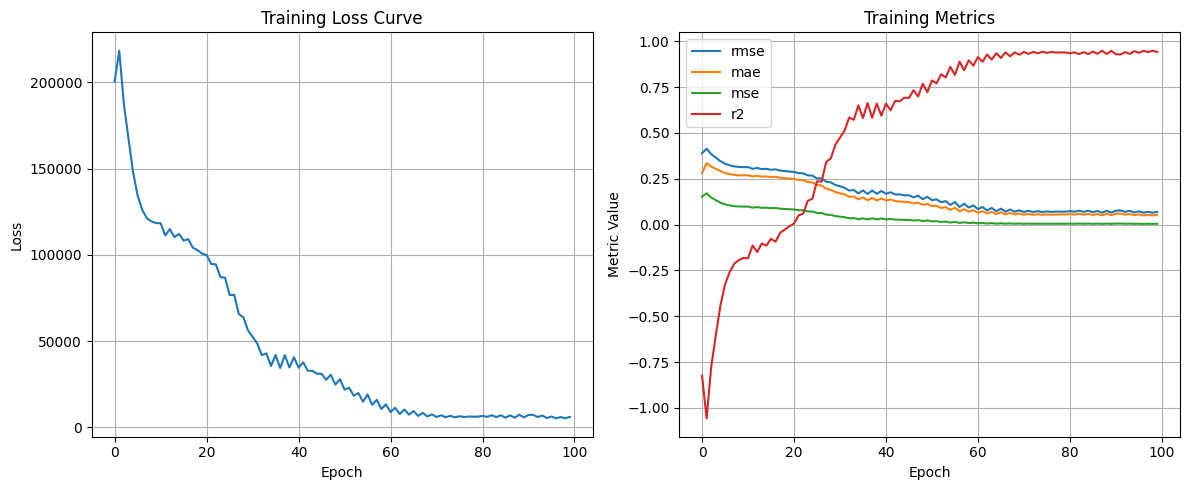

In [212]:
plot_training_history(
    train_results['train_loss'],
    {
        'rmse': train_results['train_rmse'],
        'mae': train_results['train_mae'],
        'mse': train_results['train_mse'],
        'r2': train_results['train_r2'],
    }
)

In [377]:
len(test_loader)

113

In [216]:
model.load_state_dict(torch.load('best_r2_model.pth', weights_only=True))

def test(
    model,
    test_loader,
    device,
):
    model.eval()

    test_preds = []
    test_targets = []

    test_r2 = []
    test_mae = []
    test_mse = []
    test_rmse = []
    
    with torch.no_grad():
        for data, labels in tqdm(test_loader):
            data = data.to(device)
            labels = labels.to(device)
            predictions = model(data).flatten()
            
            # predictions = torch.cummin(predictions.flip(0), dim=0).values.flip(-1)

            test_preds.append(predictions)
            test_targets.append(labels)

        test_preds = torch.cat(test_preds).cpu().detach().numpy()
        test_targets = torch.cat(test_targets).cpu().detach().numpy()

        mse = mean_squared_error(test_targets, test_preds)

        test_r2.append(r2_score(test_targets, test_preds))
        test_mae.append(mean_absolute_error(test_targets, test_preds))
        test_mse.append(mse)
        test_rmse.append(np.sqrt(mse))

    return {
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_preds': test_preds,
        'test_targets': test_targets,
    }
          

In [217]:
test_results = test(model, test_loader, device)

test_results

100%|██████████| 22/22 [00:00<00:00, 546.00it/s]


{'test_r2': [0.38191235736486995],
 'test_mae': [0.1454507],
 'test_mse': [0.033705663],
 'test_rmse': [0.18359102],
 'test_preds': array([ 1.07995343e+00,  1.18742120e+00,  1.24200344e+00,  1.26929283e+00,
         1.20624220e+00,  1.12949145e+00,  1.20146406e+00,  1.30117500e+00,
         1.27392340e+00,  1.24483049e+00,  1.25188971e+00,  1.22789645e+00,
         1.22546732e+00,  1.40527380e+00,  1.40105426e+00,  1.30577624e+00,
         1.44650209e+00,  1.41768157e+00,  1.43294883e+00,  1.47019100e+00,
         1.44720519e+00,  1.45951891e+00,  1.45798481e+00,  1.47526646e+00,
         1.52114761e+00,  1.36400211e+00,  1.33097720e+00,  1.43057323e+00,
         1.33858287e+00,  1.28889251e+00,  1.20469570e+00,  1.11098826e+00,
         1.16299736e+00,  1.16525066e+00,  1.12204432e+00,  1.09477806e+00,
         1.09263718e+00,  1.11343181e+00,  1.11097443e+00,  1.07965004e+00,
         1.12400591e+00,  1.10025895e+00,  1.05122888e+00,  1.00774753e+00,
         9.36623991e-01,  9.86567

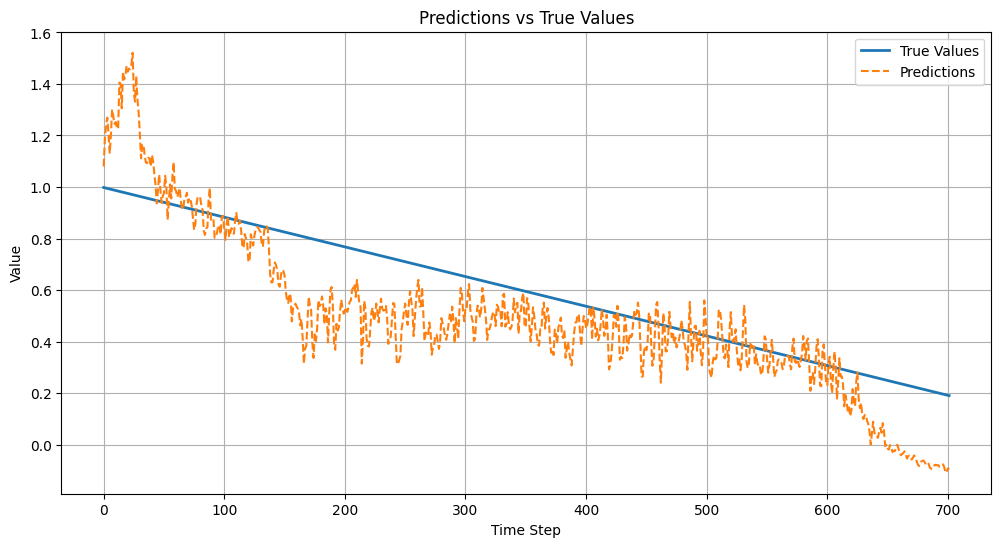

In [218]:
plot_predictions_vs_actuals(
    test_results['test_targets'],
    test_results['test_preds']
)

In [ ]:
test_results['test_targets']

(4602, 1)

In [300]:
test_results['test_preds']

array([0.02777791, 0.02777791, 0.02777791, ..., 0.02777791, 0.02777791,
       0.02777791], dtype=float32)

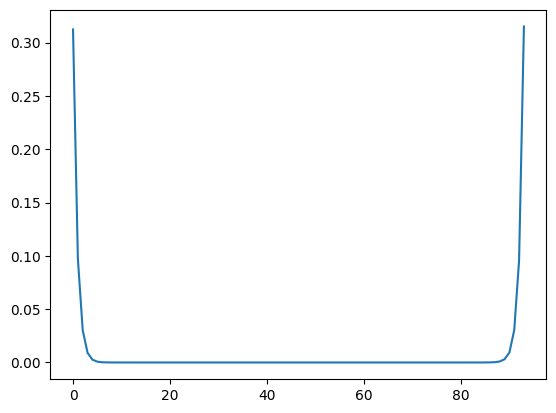

In [151]:
plt.plot(test_results['rul'].cpu().numpy())